## Market Analysis

In [ ]:
# Last changed 18/11/2025

import sys
import glob
import os
import re
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter, MaxNLocator
import numpy as np
from datetime import datetime
from typing import Dict, Optional, List

In [ ]:
# ╔═════════════════════════════╗
# ║ ✏️ VA CLIENT REQUIREMENTS   ║

client_id = "leonard_wappling"
budget = [10_000, 17_000]
year = 2012                     # Newer than or equal to
odo = [50, 150]                 # Odometer between
model_short = "civic"
model_name = "Honda civic"
n_shortlisted = 10              # Number of shortlisted cars

# ╚═════════════════════════════╝

In [ ]:
# ---------- Constants ----------
YEAR_MIN, YEAR_MAX = 1980, 2035
ORDER: List[str] = ['href', 'year_make_model', 'trim', 'price', 'transmission', 'odometer', 'seller_type']

YEAR_RE  = r'\b(19[89]\d|20[0-3]\d)\b'
PRICE_RE = r'^\s*\$\s*[\d,]+(?:\.\d{2})?\b'
ODOM_RE  = r'^\s*\d{1,3}(?:,\d{3})+\s*km\s*$'
URL_RE   = r'^(?:https?://|www\.)'
TX, SELLER = {'automatic', 'manual'}, {'private', 'dealer used'}

THRESH: Dict[str, float] = {
    'year_make_model': 0.50,
    'price':           0.60,
    'transmission':    0.80,
    'odometer':        0.60,
    'seller_type':     0.70,
}

# ---------- Predicates ----------
def _ratio(mask: pd.Series) -> float:
    return float(mask.mean()) if len(mask) else 0.0

def _yr_ok(s: pd.Series) -> pd.Series:
    years = pd.to_numeric(s.astype(str).str.extract(YEAR_RE, expand=False), errors='coerce')
    return years.between(YEAR_MIN, YEAR_MAX)

PRED = {
    'year_make_model': lambda s: s.astype(str).pipe(_yr_ok) & s.astype(str).str.contains(r'[A-Za-z]', na=False),
    'price':           lambda s: s.astype(str).str.match(PRICE_RE, na=False),
    'transmission':    lambda s: s.astype(str).str.strip().str.lower().isin(TX),
    'odometer':        lambda s: s.astype(str).str.match(ODOM_RE, flags=re.I, na=False),
    'seller_type':     lambda s: s.astype(str).str.strip().str.lower().isin(SELLER),
}

# ---------- Core ----------
def identify_columns(df: pd.DataFrame) -> Dict[str, Optional[str]]:
    """Identify and map each canonical column."""
    cols = list(df.columns)
    if not cols:
        return {k: None for k in ORDER}

    href_col = cols[0]

    # exclude URL-like columns from other detection
    url_ratio = {c: _ratio(df[c].astype(str).str.contains(URL_RE, case=False, na=False)) for c in cols}
    urlish = {c for c, r in url_ratio.items() if r >= 0.50}
    blocked = {href_col} | urlish

    remaining = [c for c in cols if c not in blocked]
    picks = {t: None for t in PRED}

    for t in PRED:
        if not remaining:
            break
        scores = {c: _ratio(PRED[t](df[c])) for c in remaining}
        best_col, best_score = max(scores.items(), key=lambda kv: kv[1])
        if best_score >= THRESH[t]:
            picks[t] = best_col
            remaining.remove(best_col)

    trim_col = None
    ymm = picks.get('year_make_model')
    if ymm in cols:
        i = cols.index(ymm)
        if i + 1 < len(cols):
            trim_col = cols[i + 1]

    return {'href': href_col, **picks, 'trim': trim_col}

# ---------- Cleaning ----------
def clean_and_rename_cs(df: pd.DataFrame) -> pd.DataFrame:
    """Detect, rename, clean numeric/text data, and return standardized columns."""
    mapping = identify_columns(df)
    out = pd.DataFrame()

    # Map columns
    if mapping['href'] is not None:
        out['href'] = df[mapping['href']]
    for col in ['year_make_model', 'trim', 'price', 'transmission', 'odometer', 'seller_type']:
        src = mapping.get(col)
        if src is not None:
            out[col] = df[src]

    # Split "year make model"
    if 'year_make_model' in out.columns:
        split_cols = out['year_make_model'].astype(str).str.split(expand=True, n=2)
        split_cols.columns = ['year', 'make', 'model']
        out = pd.concat([out, split_cols], axis=1)

    # Clean hrefs (remove query strings)
    if 'href' in out.columns:
        out['href'] = out['href'].astype(str).str.split('?').str[0]

    # Clean numeric columns
    for col in ['price', 'odometer']:
        if col in out.columns:
            out[col] = (
                out[col].astype(str)
                .replace('[^\\d]', '', regex=True)
                .replace('', pd.NA)
                .astype(float)
                .astype('Int64')
            )

    # Convert odometer to thousands of km
    if 'odometer' in out.columns:
        out['odometer'] = out['odometer'] // 1000

    # Add scrape date
    out['date_scraped'] = datetime.today().date()

    # Build final tidy table
    final_cols = ['href', 'year', 'make', 'model', 'price', 'trim', 'odometer', 'seller_type', 'date_scraped']
    return out[[c for c in final_cols if c in out.columns]]

In [ ]:
# Reading all carsales csvs
# path = os.path.join(os.getcwd(), client_id)
path = ""
files = glob.glob(os.path.join(path, "carsales*.csv"))
cs = pd.concat([clean_and_rename_cs(pd.read_csv(f)) for f in files], ignore_index=True)

# Dropping duplicates
cs['href'] = cs['href'].astype(str)
cs = cs.drop_duplicates(subset=['href'], keep='first')
print(f"{len(cs)} carsales listings.")

cs.head(5)

# ╔═════════════════════════════╗
# ║    🔎 VA TO CHECK OUTPUT    ║

# 1. Check the following columns exist and entries is correct.
# href, year, make, model, price, trim, odometer, seller_type

# ╚═════════════════════════════╝

28 carsales listings.


,href,year,make,model,price,trim,odometer,seller_type,date_scraped
0,https://www.carsales.com.au/cars/details/2013-...,2013,Honda,Civic,17888,VTi-L Auto F,25,Dealer used,2025-11-20
1,https://www.carsales.com.au/cars/details/2012-...,2012,Honda,Civic,12888,VTi-S Auto F,106,Private,2025-11-20
2,https://www.carsales.com.au/cars/details/2012-...,2012,Honda,Civic,7500,VTi-L Auto F,230,Private,2025-11-20
3,https://www.carsales.com.au/cars/details/2012-...,2012,Honda,Civic,12900,VTi Auto F,77,Private,2025-11-20
4,https://www.carsales.com.au/cars/details/2012-...,2012,Honda,Civic,8250,VTi-L Auto F,203,Private,2025-11-20


In [ ]:
def clean_fb(df):
    # Split the b column into 'year', 'make', 'model'
    df[['year', 'make', 'model']] = df['b'].str.split(expand=True, n=2)



    # Rename columns
    rename_columns = {
        "x1i10hfl href": "href",
        "a": "price",
        "c": "location",
        "d": "odometer",
    }

    # If marketplace scrape does not have column "c"
    if "c" not in df.columns:
      df["c"] = "NA"

    df.rename(columns=rename_columns, inplace=True)


    # removing query string
    df["href"] = df['href'].str.split('?').str[0]

    # Convert price and odometer columns to integers
    df=df[df['price']!="Free"]
    df['price'] = df['price'].replace(r'[^\d]', '', regex=True).astype(float).astype('Int64')
    df['odometer'] = df['odometer'].replace(r'[^\d]', '', regex=True).astype(float).astype('Int64')

    # Add a column with today's date
    df['date_scraped'] = datetime.today().date()

    # Removing listings with null values
    df = df.dropna(subset=["price","odometer","year"])

    # Remove crashed listings
    df=df[df['price']!=12345]

    # Select only the required columns in order
    final_columns = ['href', 'year', 'make', 'model', 'price', 'odometer', 'location', 'date_scraped']
    df = df[final_columns]
    return df

In [ ]:
files = glob.glob(os.path.join(path, "facebook*.csv"))
fb = pd.concat([clean_fb(pd.read_csv(f)) for f in files], ignore_index=True)

fb['href'] = fb['href'].astype(str)
before = len(fb)
print(f"Rows starting {len(fb)}.")
fb = fb.drop_duplicates(subset=['href'], keep='first')
print(f"Rows remaining {len(fb)}.")

fb.head(5)

# ╔═════════════════════════════╗
# ║    🔎 VA TO CHECK OUTPUT    ║

# Ignore error if there's no FB Marketplace files
# 1. Check the following columns exist and entries is correct.
# href, year, make, model, price, location (NA is fine)

# ╚═════════════════════════════╝

Rows starting 32.
Rows remaining 32.


,href,year,make,model,price,odometer,location,date_scraped
0,https://www.facebook.com/marketplace/item/8315...,2014,Honda,civic,7999,176,NA,2025-11-20
1,https://www.facebook.com/marketplace/item/7978...,2015,Honda,civic,10000,183,NA,2025-11-20
2,https://www.facebook.com/marketplace/item/1876...,2015,Honda,civic,12950,142,NA,2025-11-20
3,https://www.facebook.com/marketplace/item/4191...,2013,Honda,civic,11000,117,NA,2025-11-20
4,https://www.facebook.com/marketplace/item/1482...,2013,Honda,civic,12450,113,NA,2025-11-20


In [ ]:
# ╔═════════════════════════════╗
# ║    ✏️ VA DATA SOURCE        ║

# Put a "#" infront of the code to stop it from running.

# Run this for Carsales only
# df = cs

# Run this for FB Marketplace only
# df = fb

# Run this for both Carsales and FB Marketplace
df = pd.concat([cs, fb], ignore_index=True)

# ╚═════════════════════════════╝

# Remove duplicates for cars in both carsales/fb marketplace
try:
    print(f"Carsales rows: {len(cs)}")
except NameError:
    pass
try:
    print(f"FB rows: {len(fb)}")
except NameError:
    pass

print(f"Merged Rows: {len(df)}")
df=df.drop_duplicates(subset=['year', 'price', 'odometer'])
print(f"Rows after deduplication: {len(df)}")


# ╔═════════════════════════════╗
# ║    🔎 VA TO CHECK OUTPUT    ║

# Does the number of rows after append match the input datasets?

# ╚═════════════════════════════╝

Carsales rows: 28
FB rows: 32
Merged Rows: 60
Rows after deduplication: 56


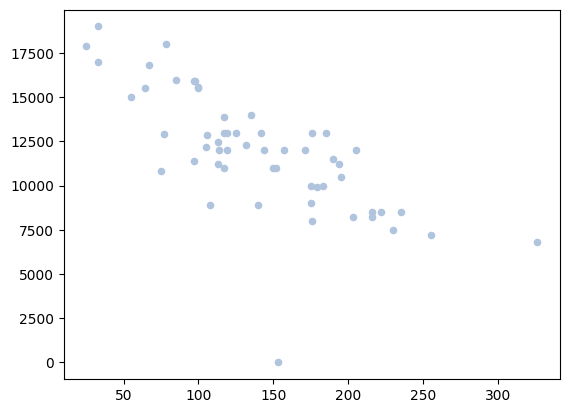

In [ ]:
plt.scatter(df['odometer'], df['price'], label='Data', color='lightsteelblue', s=20)

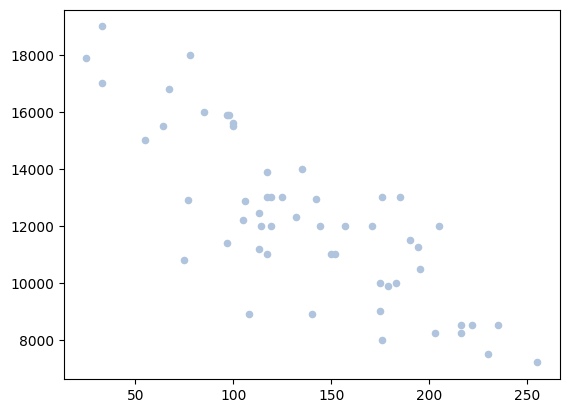

In [ ]:
# ╔═════════════════════════════╗
# ║  ✏️ VA REMOVING OUTLIERS    ║

# Removing listings with unrealistic low price
# Code keeps cars with price>X
df1 = df[df["price"]>5000]

# Remove listings with high odometer
# Code keeps cars with odo<X
df1 = df1[df1["odometer"]<270]

# Remove listings with unrealistic low odometer
# Code keeps cars with odo>X
# df1 = df1[df1["odometer"]>30]

# ╚═════════════════════════════╝

plt.scatter(df1['odometer'], df1['price'], label='Data', color='lightsteelblue', s=20)
# Save file
# df.to_csv(f"{path}/{model_short}_all.csv", index=False)
df1.to_csv(f"{client_id}_{model_short}.csv", index=False)

In [ ]:
# 0) Work on a real copy (kills SettingWithCopyWarning)
df1 = df1.copy()

# 1) Coerce to numeric (allow bad cells to become NaN)
df1['year']     = pd.to_numeric(df1['year'], errors='coerce')
df1['odometer'] = pd.to_numeric(df1['odometer'], errors='coerce')
df1['price']    = pd.to_numeric(df1['price'], errors='coerce')
df1['age'] = 2026 - df1['year']

# 2) Build X, y as float and drop rows with NaNs
X_num = df1[['age','odometer']].astype(float)
y_num = df1['price'].astype(float)
keep  = X_num.notna().all(axis=1) & y_num.notna()

X = sm.add_constant(X_num.loc[keep])
y = y_num.loc[keep]

# Optional sanity checks
assert np.isfinite(X.to_numpy()).all() and np.isfinite(y.to_numpy()).all()
assert X[['age','odometer']].std().gt(0).all()

# 3) Fit and predict
model = sm.OLS(y, X).fit()
print(model.summary())

df1.loc[keep, 'predicted_price'] = model.predict(X)
df1.loc[keep, 'value_diff'] = df1.loc[keep, 'predicted_price'] - df1.loc[keep, 'price']

print(f"Used {keep.sum()} rows; dropped {len(df1) - keep.sum()} rows.")


# ╔═════════════════════════════╗
# ║  ✏️ VA TO SAVE PARAMETERS   ║

# Save parameters in client/current_search (sheets)
# Column "coef"
# Row "const"
# Row "age"
# Row "odometer"

# ╚═════════════════════════════╝


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     61.48
Date:                Thu, 20 Nov 2025   Prob (F-statistic):           2.58e-14
Time:                        04:50:14   Log-Likelihood:                -473.56
No. Observations:                  54   AIC:                             953.1
Df Residuals:                      51   BIC:                             959.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.574e+04   2658.613      9.683      0.0

In [ ]:
# Identify n best value cars
within_crit = df1[
    (df1["price"]<budget[1]) & (df1['price']>budget[0])
    & (df1['year']>=year)
    & (df1['odometer']<odo[1]) & (df1['odometer']>odo[0])
]

In [ ]:
# Rank the top-n best-value cars (1 = best)
best_n = within_crit.sort_values('value_diff', ascending=False).head(n_shortlisted).copy()
best_n['rank'] = np.arange(1, len(best_n) + 1)


other_listings = df1.merge(best_n, how="outer", on='href',  indicator=True) \
          .query('_merge == "left_only"') \
          .drop(columns="_merge")

In [ ]:
for _, row in best_n.iterrows():
    print(f"{model_name} {row['rank']}")
    print(f"Link: {row['href']}")
    print(f"Price: ${row['price']:,}")
    print(f"Market Value: ${row['predicted_price']:,.0f}")
    print(f"Year: {row['year']:.0f}")
    print(f"Odometer: {row['odometer']:,.0f},000km\n")


# ╔═════════════════════════════╗
# ║    🔎 VA TO VET LISTINGS    ║
# ╚═════════════════════════════╝
# Vetted listings go under
# clients/client_name [tab: Market Analysis]

Honda civic 1
Link: https://www.facebook.com/marketplace/item/1310970064120322/
Price: $10,800
Market Value: $14,080
Year: 2012
Odometer: 75,000km

Honda civic 2
Link: https://www.facebook.com/marketplace/item/4191972501091381/
Price: $11,000
Market Value: $12,941
Year: 2013
Odometer: 117,000km

Honda civic 3
Link: https://www.facebook.com/marketplace/item/1878707916391578/
Price: $11,200
Market Value: $13,108
Year: 2013
Odometer: 113,000km

Honda civic 4
Link: https://www.carsales.com.au/cars/details/2014-honda-civic-vti-l-auto-my13/SSE-AD-19103168/
Price: $12,200
Market Value: $14,051
Year: 2014
Odometer: 105,000km

Honda civic 5
Link: https://www.facebook.com/marketplace/item/677215988733918/
Price: $11,400
Market Value: $13,164
Year: 2012
Odometer: 97,000km

Honda civic 6
Link: https://www.carsales.com.au/cars/details/2012-honda-civic-vti-auto/SSE-AD-19686299/
Price: $12,900
Market Value: $13,997
Year: 2012
Odometer: 77,000km

Honda civic 7
Link: https://www.facebook.com/marketplac

## Shortlist For Client

In [ ]:
# ╔═════════════════════════════╗
# ║     VA PLEASE IGNORE        ║
from google.colab import drive
drive.mount('/content/drive')
# ╚═════════════════════════════╝

Mounted at /content/drive


In [ ]:
# ╔═════════════════════════════╗
# ║    ✏️ VA TO EDIT            ║
client_id = "leonard_wappling"
model_short = "hondajazz"
model_name = "Honda Jazz"
# ╚═════════════════════════════╝


In [ ]:
# Reading in [client_id]_[model_short].csv
df1 = pd.read_csv(f"/content/drive/MyDrive/Clients/paid/{client_id}_{model_short}.csv")
# df1 = pd.read_csv(f"{client_id}_{model_short}.csv")
df1["nego_price"] = pd.NA
df1.head()

# ╔═════════════════════════════╗
# ║    🔎 VA TO CHECK OUTPUT    ║

# 1. Check the following columns exist and entries is correct.
# href, year, make, model, price, trim, odometer, seller_type

# ╚═════════════════════════════╝


,Unnamed: 0,href,year,make,model,price,trim,odometer,seller_type,date_scraped,location,nego_price
0,0,https://www.carsales.com.au/cars/details/2019-...,2019,Honda,Jazz,15450,VTi Manual F MY19,110,Dealer used,2025-11-17,NaN,<NA>
1,1,https://www.carsales.com.au/cars/details/2018-...,2018,Honda,Jazz,17888,VTi Auto F MY19,70,Private,2025-11-17,NaN,<NA>
2,2,https://www.carsales.com.au/cars/details/2017-...,2017,Honda,Jazz,15990,VTi-L Auto F MY17,90,Private,2025-11-17,NaN,<NA>
3,3,https://www.carsales.com.au/cars/details/2017-...,2017,Honda,Jazz,13000,VTi Manual F MY17,71,Private,2025-11-17,NaN,<NA>
4,4,https://www.carsales.com.au/cars/details/2017-...,2017,Honda,Jazz,14700,VTi Auto F MY17,82,Private,2025-11-17,NaN,<NA>


In [ ]:
# ╔═════════════════════════════════╗
# ║ ✏️ VA TO ADD NEGOTIATED PRICE   ║


# href1 = "https://www.carsales.com.au/cars/details/2014-honda-civic-vti-l-auto-my13/SSE-AD-19103168/"
# df1.loc[df1["href"]==href1,"nego_price"]=11000

href2 = "https://www.carsales.com.au/cars/details/2016-honda-jazz-vti-auto-my17/SSE-AD-19649502/"
df1.loc[df1["href"]==href2,"nego_price"]=14000

# ╚═════════════════════════════════╝

In [ ]:
# ╔═════════════════════════════════╗
# ║ ✏️ VA TO ADD LISTINGS IF NEEDED ║

df1.loc[len(df1)] = {
    "href": "https://www.onlycars.com.au/sedan/lexus/2016-lexus-is300h-f-sport-hybrid-1337934764_976d4c41-2b7f-4999-b70b-b9b44064d6fa",
    "year": 2016,
    "make": "Lexus",
    "model": "IS300h",
    "price": 25000,
    "nego_price": 23000,
    "odometer": 67,
}

# df1.loc[len(df1)] = {
#     "href": "https://www.onlycars.com.au/sedan/lexus/2016-lexus-is300h-f-sport-hybrid-1337934764_976d4c41-2b7f-4999-b70b-b9b44064d6fa",
#     "year": 2016,
#     "make": "Lexus",
#     "model": "IS300h",
#     "price": 25000,
#     "nego_price": 23000,
#     "odometer": 67,
# }

# ╚═════════════════════════════════╝

In [ ]:
# Building Regression Model
# 0) Work on a real copy (kills SettingWithCopyWarning)
df1 = df1.copy()

# 1) Coerce to numeric (allow bad cells to become NaN)
df1['year']     = pd.to_numeric(df1['year'], errors='coerce')
df1['odometer'] = pd.to_numeric(df1['odometer'], errors='coerce')
df1['price']    = pd.to_numeric(df1['price'], errors='coerce')
df1['age'] = 2026 - df1['year']

# 2) Build X, y as float and drop rows with NaNs
X_num = df1[['age','odometer']].astype(float)
y_num = df1['price'].astype(float)
keep  = X_num.notna().all(axis=1) & y_num.notna()

X = sm.add_constant(X_num.loc[keep])
y = y_num.loc[keep]

# Optional sanity checks
assert np.isfinite(X.to_numpy()).all() and np.isfinite(y.to_numpy()).all()
assert X[['age','odometer']].std().gt(0).all()

# 3) Fit and predict
model = sm.OLS(y, X).fit()
print(model.summary())

df1.loc[keep, 'predicted_price'] = model.predict(X)
df1.loc[keep, 'value_diff'] = df1.loc[keep, 'predicted_price'] - df1.loc[keep, 'price']

print(f"Used {keep.sum()} rows; dropped {len(df1) - keep.sum()} rows.")

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     31.19
Date:                Thu, 20 Nov 2025   Prob (F-statistic):           4.27e-09
Time:                        07:07:54   Log-Likelihood:                -394.41
No. Observations:                  46   AIC:                             794.8
Df Residuals:                      43   BIC:                             800.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.273e+04   1063.048     21.382      0.0

In [ ]:
# ╔═════════════════════════════════╗
# ║ ✏️ VA TO PASTE SHORLIST HREFS   ║

specific_cars = df1[df1["href"].isin([
    # "https://www.carsales.com.au/cars/details/2017-honda-jazz-vti-auto-my17/SSE-AD-19588166/",
    "https://www.onlycars.com.au/sedan/lexus/2016-lexus-is300h-f-sport-hybrid-1337934764_976d4c41-2b7f-4999-b70b-b9b44064d6fa",
    "https://www.carsales.com.au/cars/details/2018-lexus-is-is300-luxury-auto/OAG-AD-24865146/",
])]

# ╚═════════════════════════════════╝

nego_cars = df1[df1["nego_price"].notna()]
within_crit = pd.concat([specific_cars, nego_cars])

In [ ]:
# Rank the top-n best-value cars (1 = best)
best_n = within_crit.sort_values('value_diff', ascending=False).head(n_shortlisted).copy()
best_n['rank'] = np.arange(1, len(best_n) + 1)

other_listings = df1.merge(best_n, how="outer", indicator=True) \
          .query('_merge == "left_only"') \
          .drop(columns="_merge")

In [ ]:
for _, row in best_n.iterrows():
    print(f"{model_name} {row['rank']}")
    print(f"Link: {row['href']}")
    print(f"Market Value: ${row['predicted_price']:,.0f}")
    print(f"Listed Price: ${row['price']:,}")
    try:
        print(f"Negotiated Price: ${row['nego_price']:,.0f}")
    except KeyError as e:
        pass
    print(f"Year: {row['year']:.0f}")
    print(f"Odometer: {row['odometer']:,.0f},000km\n")

Honda Jazz 1
Link: https://www.carsales.com.au/cars/details/2016-honda-jazz-vti-auto-my17/SSE-AD-19649502/
Market Value: $16,940
Listed Price: $16,000
Negotiated Price: $14,000
Year: 2016
Odometer: 43,000km



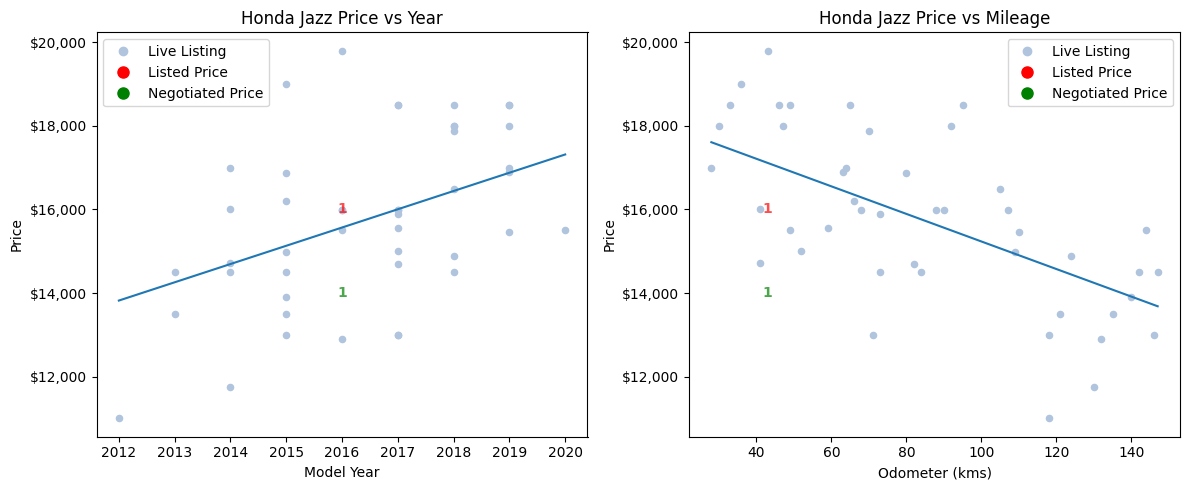

In [ ]:
# Function to format price axis
def price_format(x, _):
    return f'${int(x):,}'

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Compute age
other_listings['age'] = 2026 - other_listings['year']
best_n['age'] = 2026 - best_n['year']

# Scatter (Year vs Price)
ax1.scatter(other_listings['year'], other_listings['price'],
            label='Data', color='lightsteelblue', s=20)

for _, row in best_n.iterrows():
    ax1.scatter(row['year'], row['price'], s=70, facecolors='none', linewidths=1.2)
    ax1.text(row['year'], row['price'], str(int(row['rank'])),
             ha='center', va='center', fontsize=10, fontweight='bold',
             color='red', alpha=0.7)
    if not pd.isna(row['nego_price']):
        ax1.text(row['year'], row['nego_price'], str(int(row['rank'])),
                 ha='center', va='center', fontsize=10, fontweight='bold',
                 color='green', alpha=0.7)

# Regression line (fix odometer at mean)
year_range = np.linspace(other_listings['year'].min(),
                         other_listings['year'].max(), 100)

age_range = 2026 - year_range  # convert back to age for model input
mean_odometer = other_listings['odometer'].mean()

X_line = pd.DataFrame({
    'const': 1,
    'age': age_range,
    'odometer': [mean_odometer] * 100
})

y_line = model.predict(X_line)

ax1.plot(year_range, y_line, label='Regression line')

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.yaxis.set_major_formatter(FuncFormatter(price_format))
ax1.set_xlabel('Model Year')
ax1.set_ylabel('Price')
ax1.set_title(f"{model_name} Price vs Year")

# Scatter (Odometer vs Price)
ax2.scatter(other_listings['odometer'], other_listings['price'],
            label='Data', color='lightsteelblue', s=20)

for _, row in best_n.iterrows():
    ax2.scatter(row['odometer'], row['price'], s=70, facecolors='none', linewidths=1.2)
    ax2.text(row['odometer'], row['price'], str(int(row['rank'])),
             ha='center', va='center', fontsize=10, fontweight='bold',
             color='red', alpha=0.7)
    if not pd.isna(row['nego_price']):
        ax2.text(row['odometer'], row['nego_price'], str(int(row['rank'])),
                 ha='center', va='center', fontsize=10, fontweight='bold',
                 color='green', alpha=0.7)

# Regression line (fix age at mean)
odometer_range = np.linspace(other_listings['odometer'].min(),
                             other_listings['odometer'].max(), 100)

mean_age = other_listings['age'].mean()

X_line2 = pd.DataFrame({
    'const': 1,
    'age': [mean_age] * 100,
    'odometer': odometer_range
})

y_line2 = model.predict(X_line2)
ax2.plot(odometer_range, y_line2, label='Regression line')

ax2.yaxis.set_major_formatter(FuncFormatter(price_format))
ax2.set_xlabel('Odometer (kms)')
ax2.set_ylabel('Price')
ax2.set_title(f"{model_name} Price vs Mileage")


# Legend handles
live_listing_handle = Line2D([], [], marker='o', color='lightsteelblue', linestyle='None', markersize=6, label='Live Listing')
listed_price_handle = Line2D([], [], marker='o', color='red', linestyle='None',
                                 markersize=8, label='Listed Price')
negotiated_price_handle = Line2D([], [], marker='o', color='green', linestyle='None',
                                 markersize=8, label='Negotiated Price')

# Apply legend to both subplots
ax1.legend(handles=[live_listing_handle, listed_price_handle, negotiated_price_handle])
ax2.legend(handles=[live_listing_handle, listed_price_handle, negotiated_price_handle])


plt.tight_layout()
plt.show()